<a href="https://colab.research.google.com/github/SaiPavanKumarB/Music-Review-Ratings-Prediction/blob/main/Sri_Music_Ratings_Prediction_By_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Ratings Prediction based on reviews*


---



## Import libraries

In [65]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Read file

The ratings are provided as JSON file, which is loaded to GitHub for easy access.
File contains below details/columns


*   reviewerID
*   asin
*   reviewerName
*   helpful
*   reviewText - This is the main review that should be used for classification
*   overall - Ratings (Target column)
*   summary - Quick jist of the detailed review
*   Unixtime, reviewTime - Time columns


In [2]:
url = 'https://raw.githubusercontent.com/SaiPavanKumarB/Music-Review-Ratings-Prediction/main/Musical_Instruments_5.json'
df = pd.read_json(url,orient='records',dtype='dict',lines=True)
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"


In [3]:
df.shape

(10261, 9)

In [4]:
# convert the target column data type to int
df['overall'] = df['overall'].astype(int)

## Explore the Data

### Is the Dataset balanced?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


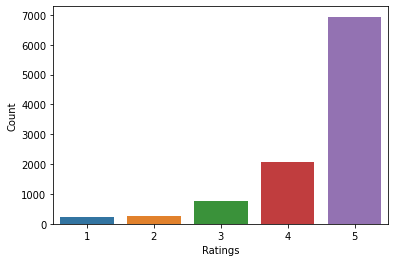

In [19]:
# Check the target column distribution
temp = pd.DataFrame(df['overall'].value_counts()).reset_index()
sns.barplot(temp['index'],temp['overall'])
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

The dataset is highly imbalanced as there are more records for ratings 4,5 compared to the rest 3 ratings

Let's split the helpful column (list) to 2 seperate columns to see if it has something to say

In [20]:
df[['helpful_1','helpful_2']] = pd.DataFrame(df['helpful'].to_list())

Not much to offer here it seems

### Any relation between number of words/length of review Vs Rating?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


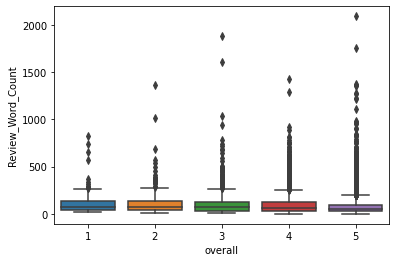

In [24]:
df['Review_Word_Count'] = df['reviewText'].apply(lambda x: len(re.findall(r'\w+', x)))

sns.boxplot(df['overall'],df['Review_Word_Count'])

Seems to have some relation, as lower ratings tend to have few words (including outliers)

### Any relation between number of unique words Vs Rating?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


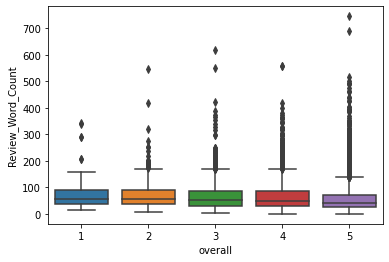

In [25]:
df['Review_Word_Count'] = df['reviewText'].apply(lambda x: len(set(re.findall(r'\w+', x))))

sns.boxplot(df['overall'],df['Review_Word_Count'])

Yes. Unique words seems to show us some difference

### How about Authors Vs Ratings?

In [26]:
df['reviewerName'].value_counts()

Amazon Customer                 66
StormJH1                        42
David G                         38
David W "Dave"                  38
John                            37
                                ..
TheSunrisePost                   2
Rad5030                          2
caffeinebrain                    2
ManUPT                           1
Amazon Customer "kateTaylor"     1
Name: reviewerName, Length: 1397, dtype: int64

We've about 1397 authors overall. Let's take the top 10 whose has most reviews to see the relation

### Ratings distribution of authors with most reviews (Top 20)

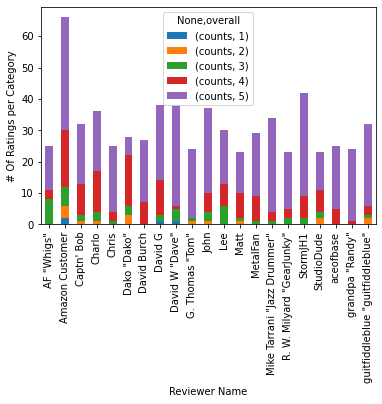

In [50]:
temp = pd.DataFrame(df['reviewerName'].value_counts()).reset_index()[:21]

temp2 = pd.DataFrame()
for i in temp['index']:
  subset = pd.DataFrame(df[df['reviewerName']==i][['reviewerName','overall']])
  temp2 = temp2.append(subset)
temp3 = pd.DataFrame(temp2.groupby(['reviewerName','overall']).size().reset_index(name='counts'))
temp4 = temp3.pivot(columns='overall',index='reviewerName').fillna(0)
temp4.plot(kind='bar',stacked=True,legend=True)
plt.xlabel('Reviewer Name')
plt.ylabel('# Of Ratings per Category')
plt.show()


Seems most of them are happy customers as for 80% of their ratings fall in 4,5 categories. Is this why the dataset is skewed? Are all happy customers?

### Ratings distribution of Authors with least reviews (Bottom 20)

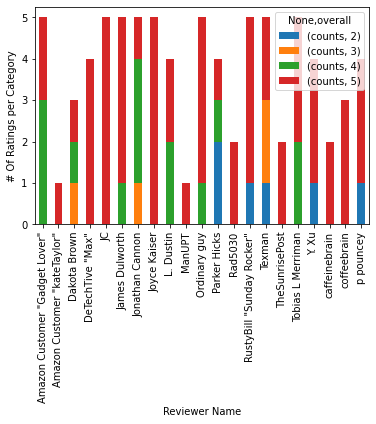

In [53]:
temp = pd.DataFrame(df['reviewerName'].value_counts()).reset_index()[-21:]

temp2 = pd.DataFrame()
for i in temp['index']:
  subset = pd.DataFrame(df[df['reviewerName']==i][['reviewerName','overall']])
  temp2 = temp2.append(subset)
temp3 = pd.DataFrame(temp2.groupby(['reviewerName','overall']).size().reset_index(name='counts'))
temp4 = temp3.pivot(columns='overall',index='reviewerName').fillna(0)
temp4.plot(kind='bar',stacked=True,legend=True)
plt.xlabel('Reviewer Name')
plt.ylabel('# Of Ratings per Category')
plt.show()

Ok. Even with customers with least reviews, it seems majority are satisfied/happy customers

## Base line model (using reviews alone)

### Consider only reviews & ratings

Let's create a base line model following the below steps
*   Create dataframe using review & ratings alone
*   Tokenize the reviews
*   Create TF-IDF sparse matrix
*   Create Logistic Regression model









In [57]:
review_df = df[['reviewText','overall']]
review_df.rename({'reviewText':'Review','overall':'Rating'},axis=1,inplace=True)
review_df.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Review,Rating
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5


Split to train test with 80:20 ratio

In [59]:
review_df['Rating'] = review_df['Rating'].astype('category')
X = review_df.Review
y = review_df.Rating

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### TF-IDF Vectorizor
While using TF-IDF, we are considering the below
*   max_df is set to 0.75 
*   Consider bigrams as well



In [95]:
stopwords = list(set(nltk.corpus.stopwords.words('english')))
lemmatizer = WordNetLemmatizer()

def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text) if len(word)>3]
  tokens = [x for x in tokens if x not in stopwords]
  lemma = [lemmatizer.lemmatize(x) for x in tokens]
  return lemma

In [96]:
# Fit the TfIDF on train data set & transform both train & test datasets
tfidf_vec = TfidfVectorizer(tokenizer=tokenize,lowercase=True,max_features=1000,
                             max_df=0.75, ngram_range=(1, 2), stop_words=None)
tfidf_vec.fit(X_train)

xtrain = tfidf_vec.transform(X_train)
xtest = tfidf_vec.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Word Cloud for each Rating

In [154]:
stopwords.append('sound')

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Word Cloud for Rating :  1


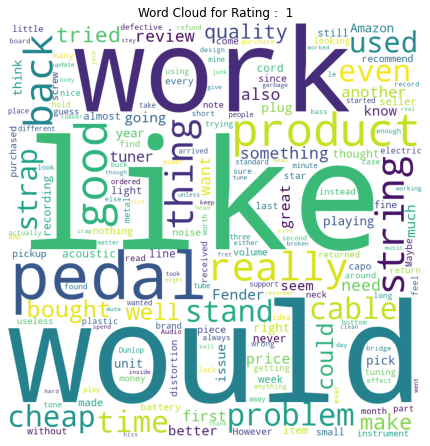

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Word Cloud for Rating :  2


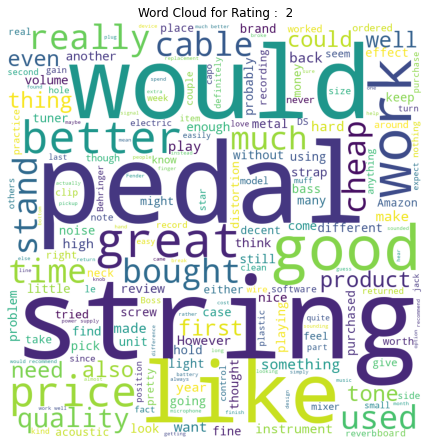

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Word Cloud for Rating :  3


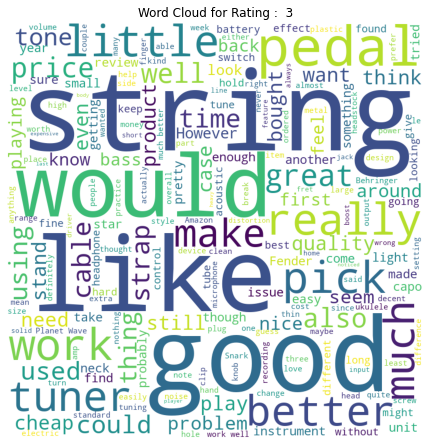

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Word Cloud for Rating :  4


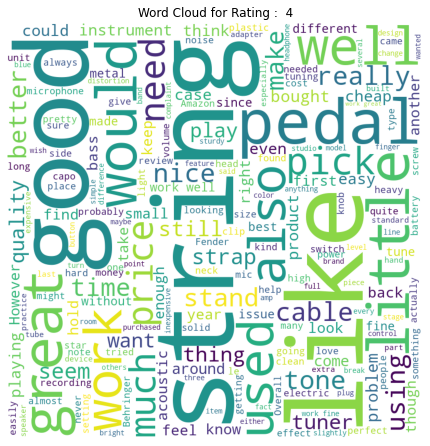

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Word Cloud for Rating :  5


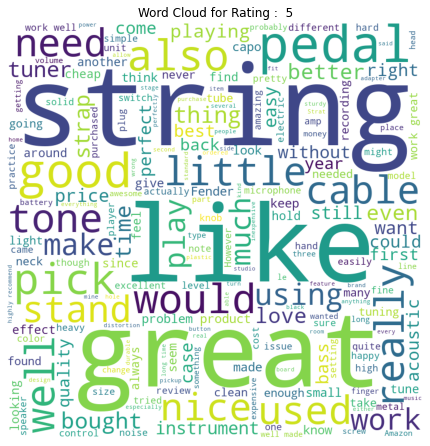

In [155]:
from wordcloud import WordCloud

for i in range(1,6):
  print('*-'*30)
  print('Word Cloud for Rating : ',i)
  samp_df = review_df[review_df['Rating']==i]['Review']
  samp_df = samp_df.reset_index()
  comment_words = ''

  for r in range(samp_df.shape[0]):
    text = samp_df.loc[r]['Review']
    tokens = tokenize(text)
    comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
  # plot the WordCloud image                       
  plt.figure(figsize = (6, 6), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title('Word Cloud for Rating : {0:2d}'.format(i))
  plt.tight_layout(pad = 0)
  plt.show()

### Logistic Regression (with class_weights = 'balanced')



Classification Report
******************************
              precision    recall  f1-score   support

           1       0.10      0.29      0.15        42
           2       0.09      0.29      0.14        56
           3       0.16      0.36      0.22       149
           4       0.33      0.37      0.35       435
           5       0.83      0.58      0.68      1371

    accuracy                           0.50      2053
   macro avg       0.30      0.37      0.31      2053
weighted avg       0.64      0.50      0.55      2053

Confusion Matrix
******************************


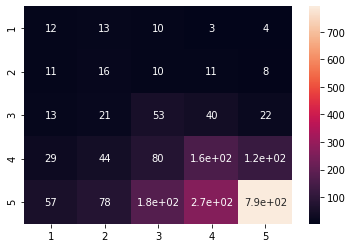

In [97]:
lg_model = LogisticRegression(class_weight='balanced',multi_class='auto',max_iter=1000) # Allow model to calculate class weights
lg_model.fit(xtrain,y_train)

preds = lg_model.predict(xtest)
print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))
class_rpt = classification_report(y_test,preds)
class_rpt


print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
cm = pd.DataFrame(cm)
sns.heatmap(cm,annot=True,
            xticklabels=(pd.DataFrame(cm).index+1),
            yticklabels=(pd.DataFrame(cm).index+1))

Not so great performance. Still the model is predicting rating 5 which is why we have better precision/recall for 5 alone

### XgBoost



Classification Report
******************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        56
           3       0.40      0.01      0.03       149
           4       0.41      0.07      0.12       435
           5       0.68      0.98      0.81      1371

    accuracy                           0.67      2053
   macro avg       0.30      0.21      0.19      2053
weighted avg       0.57      0.67      0.57      2053

Confusion Matrix
******************************


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


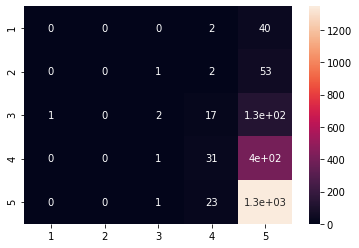

In [98]:
xgb_clf = xgb.XGBClassifier(n_estimators=200,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10)
xgb_clf.fit(xtrain,y_train)

preds = xgb_clf.predict(xtest)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
cm = pd.DataFrame(cm)
sns.heatmap(cm,annot=True,
            xticklabels=(pd.DataFrame(cm).index+1),
            yticklabels=(pd.DataFrame(cm).index+1))

Not great

### Random Forest



Classification Report
******************************
              precision    recall  f1-score   support

           1       0.05      0.14      0.08        42
           2       0.07      0.11      0.09        56
           3       0.11      0.28      0.16       149
           4       0.27      0.30      0.29       435
           5       0.77      0.56      0.65      1371

    accuracy                           0.47      2053
   macro avg       0.26      0.28      0.25      2053
weighted avg       0.58      0.47      0.51      2053

Confusion Matrix
******************************


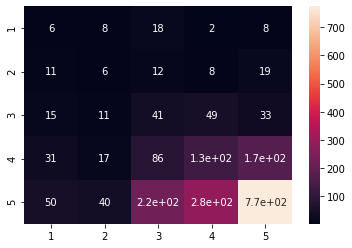

In [99]:
RGB_Classifier = RandomForestClassifier(n_estimators=400,
                                        class_weight='balanced_subsample',max_depth=8)

RGB_Classifier.fit(xtrain,y_train)

preds = RGB_Classifier.predict(xtest)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
cm = pd.DataFrame(cm)
sns.heatmap(cm,annot=True,
            xticklabels=(pd.DataFrame(cm).index+1),
            yticklabels=(pd.DataFrame(cm).index+1))

This is better, but not better than Logistic Regression at predicting all classes

### Use SMOTE for Over Sampling the Minority Classes

In [103]:
from imblearn.over_sampling import SMOTE

over = SMOTE(sampling_strategy='auto')
xtrain_resamp,y_train_resamp = over.fit_resample(xtrain,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Logistic Regression - After SMOTE



Classification Report
******************************
              precision    recall  f1-score   support

           1       0.11      0.24      0.15        42
           2       0.10      0.27      0.15        56
           3       0.13      0.26      0.18       149
           4       0.29      0.33      0.31       435
           5       0.81      0.60      0.69      1371

    accuracy                           0.50      2053
   macro avg       0.29      0.34      0.29      2053
weighted avg       0.62      0.50      0.55      2053

Confusion Matrix
******************************


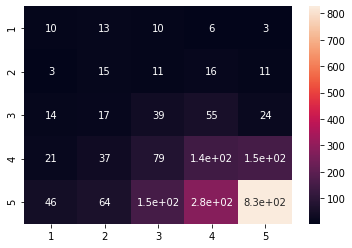

In [104]:
lg_model = LogisticRegression(multi_class='multinomial',max_iter=1000) # Allow model to calculate class weights
lg_model.fit(xtrain_resamp,y_train_resamp)

preds = lg_model.predict(xtest)
print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))
class_rpt = classification_report(y_test,preds)
class_rpt


print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
cm = pd.DataFrame(cm)
sns.heatmap(cm,annot=True,
            xticklabels=(pd.DataFrame(cm).index+1),
            yticklabels=(pd.DataFrame(cm).index+1))

### XgBoost - After SMOTE



Classification Report
******************************
              precision    recall  f1-score   support

           1       0.10      0.05      0.06        42
           2       0.08      0.02      0.03        56
           3       0.19      0.12      0.15       149
           4       0.34      0.22      0.27       435
           5       0.71      0.85      0.78      1371

    accuracy                           0.63      2053
   macro avg       0.28      0.25      0.26      2053
weighted avg       0.57      0.63      0.59      2053

Confusion Matrix
******************************


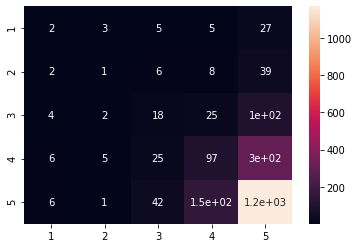

In [106]:
xgb_clf = xgb.XGBClassifier(n_estimators=200,learning_rate=0.05,max_depth=8,objective='multi:softprob',random_state=10)
xgb_clf.fit(xtrain_resamp,y_train_resamp)

preds = xgb_clf.predict(xtest)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
cm = pd.DataFrame(cm)
sns.heatmap(cm,annot=True,
            xticklabels=(pd.DataFrame(cm).index+1),
            yticklabels=(pd.DataFrame(cm).index+1))

Better than previous version of XgBoost

### Random Forest - After SMOTE



Classification Report
******************************
              precision    recall  f1-score   support

           1       0.09      0.21      0.13        42
           2       0.07      0.04      0.05        56
           3       0.12      0.14      0.13       149
           4       0.27      0.08      0.12       435
           5       0.70      0.83      0.76      1371

    accuracy                           0.59      2053
   macro avg       0.25      0.26      0.24      2053
weighted avg       0.54      0.59      0.55      2053

Confusion Matrix
******************************


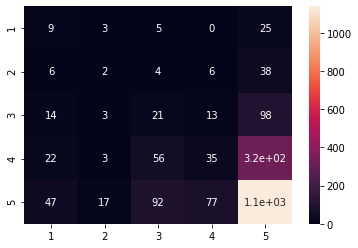

In [108]:
RGB_Classifier = RandomForestClassifier(n_estimators=400
                                        ,max_depth=8)

RGB_Classifier.fit(xtrain_resamp,y_train_resamp)

preds = RGB_Classifier.predict(xtest)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
cm = pd.DataFrame(cm)
sns.heatmap(cm,annot=True,
            xticklabels=(pd.DataFrame(cm).index+1),
            yticklabels=(pd.DataFrame(cm).index+1))

## Use Summary instead of Review for Classification

In [109]:
summary_df = df[['summary','overall']]
summary_df.rename({'overall':'Rating'},axis=1,inplace=True)
summary_df['Rating'] = summary_df['Rating'].astype('category')
X = summary_df.summary
y = summary_df.Rating

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [110]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

# Fit the TfIDF on train data set & transform both train & test datasets
tfidf_vec = TfidfVectorizer(tokenizer=tokenize,lowercase=True,max_features=1000,
                             max_df=0.75, ngram_range=(1, 2), stop_words=None)
tfidf_vec.fit(X_train)

xtrain = tfidf_vec.transform(X_train)
xtest = tfidf_vec.transform(X_test)

over = SMOTE(sampling_strategy='auto')
xtrain_resamp,y_train_resamp = over.fit_resample(xtrain,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Logistic Regresssion - SMOTE with Summary Column



Classification Report
******************************
              precision    recall  f1-score   support

           1       0.10      0.33      0.16        42
           2       0.05      0.27      0.09        56
           3       0.14      0.18      0.16       149
           4       0.33      0.35      0.34       435
           5       0.82      0.58      0.68      1371

    accuracy                           0.49      2053
   macro avg       0.29      0.34      0.28      2053
weighted avg       0.63      0.49      0.54      2053

Confusion Matrix
******************************


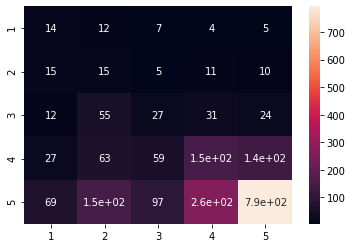

In [111]:
lg_model = LogisticRegression(multi_class='multinomial',max_iter=1000) # Allow model to calculate class weights
lg_model.fit(xtrain_resamp,y_train_resamp)

preds = lg_model.predict(xtest)
print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))
class_rpt = classification_report(y_test,preds)
class_rpt


print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
cm = pd.DataFrame(cm)
sns.heatmap(cm,annot=True,
            xticklabels=(pd.DataFrame(cm).index+1),
            yticklabels=(pd.DataFrame(cm).index+1))

### Random Forest - After SMOTE with Summary Column



Classification Report
******************************
              precision    recall  f1-score   support

           1       0.07      0.12      0.09        42
           2       0.04      0.52      0.07        56
           3       0.31      0.07      0.12       149
           4       0.35      0.34      0.34       435
           5       0.81      0.47      0.59      1371

    accuracy                           0.40      2053
   macro avg       0.32      0.30      0.24      2053
weighted avg       0.64      0.40      0.48      2053

Confusion Matrix
******************************


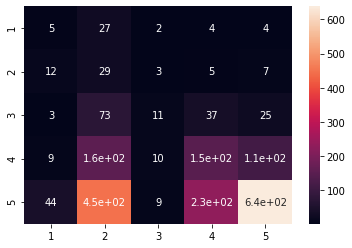

In [112]:
RGB_Classifier = RandomForestClassifier(n_estimators=400
                                        ,max_depth=8)

RGB_Classifier.fit(xtrain_resamp,y_train_resamp)

preds = RGB_Classifier.predict(xtest)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
cm = pd.DataFrame(cm)
sns.heatmap(cm,annot=True,
            xticklabels=(pd.DataFrame(cm).index+1),
            yticklabels=(pd.DataFrame(cm).index+1))